<a href="https://colab.research.google.com/github/dbusn/process-mining-group-5/blob/main/RNN_Time_Prediction2012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install matplotlib --upgrade

In [2]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import datetime as datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizer_v2 import nadam as nadam_v2
import os
import math
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib

In [3]:
#!pip install tensorflow-gpu

# 0. GPU Setting and Import CSV (https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

The requirements to use the cuDNN implementation are:

activation == tanh

recurrent_activation == sigmoid

recurrent_dropout == 0

unroll is False

use_bias is True

Inputs, if use masking, are strictly right-padded.

Eager execution is enabled in the outermost context.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Select the csv you want

from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2012_train_filtered.csv",dtype={'norm_next_activity_delta': str},  parse_dates = ['time:timestamp'])
df_val = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2012_val_filtered.csv", parse_dates = ['time:timestamp'])
df_test = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2012_test_filtered.csv", parse_dates = ['time:timestamp'])

# The default name indicating the case ID is case:concept:name
# concept:name is the event
# time:timestamp is the corresponding timestamp
# Load the datasets, sort them on case and consequently timestamp, then reset the index
df_train = df_train.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)
df_val = df_val.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)
df_test = df_test.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index(drop = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
liss = [df_train, df_test, df_val]
for df in liss: 
   for col in df.columns:
     lis = []
     for i, data in enumerate(df[col]):
       try: lis.append(round(float('0.'+ data.replace('.', '')), 5))
       except: break
     else:df[col] = lis

In [7]:
# Global Feature 1

df_train["case_occurrence_nr"] = df_train.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()
df_val["case_occurrence_nr"] = df_val.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()
df_test["case_occurrence_nr"] = df_test.groupby(['case:concept:name'])['time:timestamp'].cumcount().tolist()

min_max_scaler_occur = MinMaxScaler()
df_train['nor_case_occurrence_nr'] = min_max_scaler_occur.fit_transform(np.array(df_train['case_occurrence_nr']).reshape(-1, 1))
df_val['nor_case_occurrence_nr'] = min_max_scaler_occur.transform(np.array(df_val['case_occurrence_nr']).reshape(-1, 1))
df_test['nor_case_occurrence_nr'] = min_max_scaler_occur.transform(np.array(df_test['case_occurrence_nr']).reshape(-1, 1))

In [8]:
# Global Feature 2

def case_in_hr(df):
    df['date'] = df['time:timestamp'].dt.date
    df['hour'] = df['time:timestamp'].dt.hour
    df_1 = df.groupby(['date', 'hour']).count()[['case:concept:name']].reset_index()
    df_1.rename(columns = {'case:concept:name': 'case_nr_per_hr'}, inplace = True)
    df = pd.merge(df, df_1, on = ['date', 'hour'], how = "left")
    df.drop(columns = ['date', 'hour'], inplace = True)
    return df

df_train = case_in_hr(df_train)
df_val = case_in_hr(df_val)
df_test = case_in_hr(df_test)

min_max_scaler_case = MinMaxScaler()
df_train['nor_case_nr_per_hr'] = min_max_scaler_case.fit_transform(np.array(df_train['case_nr_per_hr']).reshape(-1, 1))
df_val['nor_case_nr_per_hr'] = min_max_scaler_case.transform(np.array(df_val['case_nr_per_hr']).reshape(-1, 1))
df_test['nor_case_nr_per_hr'] = min_max_scaler_case.transform(np.array(df_test['case_nr_per_hr']).reshape(-1, 1))

# 1. Normalization on Time Difference

In [9]:
df_train

,org:resource,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,case_occurrence_no,lifecycle:transition_is_COMPLETE,lifecycle:transition_is_SCHEDULE,lifecycle:transition_is_START,...,next_activity_delta_t,past_activity_delta_t,norm_next_activity_delta,norm_past_activity_delta,next:concept:name,day,case_occurrence_nr,nor_case_occurrence_nr,case_nr_per_hr,nor_case_nr_per_hr
0,112.0,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,0.0,1.0,0.0,0.0,...,0 days 00:00:00.334000,-1 days +23:59:59.666000,0.99971,0.99914,A_PARTLYSUBMITTED,4,0,0.000000,4,0.014778
1,112.0,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,1.0,1.0,0.0,0.0,...,0 days 00:00:53.026000,-1 days +23:59:06.974000,0.99971,0.99914,A_PREACCEPTED,4,1,0.008264,4,0.014778
2,112.0,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,2.0,1.0,0.0,0.0,...,0 days 00:00:00.969000,-1 days +23:59:59.031000,0.99971,0.99914,W_Completeren aanvraag,4,2,0.016529,4,0.014778
3,112.0,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,3.0,0.0,1.0,0.0,...,0 days 10:57:07.562000,-1 days +13:02:52.438000,0.99971,0.99914,W_Completeren aanvraag,4,3,0.024793,4,0.014778
4,NaN,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,4.0,0.0,0.0,1.0,...,0 days 00:05:56.871000,-1 days +23:54:03.129000,0.99971,0.99914,A_ACCEPTED,5,4,0.033058,33,0.157635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,10863.0,A_DECLINED,2012-01-09 16:56:28.761000+00:00,2012-01-09 17:06:34.653000+01:00,199327.0,11800.0,4.0,1.0,0.0,0.0,...,0 days 00:00:03.132000,-1 days +23:59:56.868000,0.99971,0.99914,W_Afhandelen leads,0,4,0.033058,24,0.113300
64678,10863.0,W_Afhandelen leads,2012-01-09 16:56:31.893000+00:00,2012-01-09 17:06:34.653000+01:00,199327.0,11800.0,5.0,1.0,0.0,0.0,...,-1 days +23:18:00.196000,0 days 00:41:59.804000,0.99971,0.99914,Nothing,0,5,0.041322,24,0.113300
64679,112.0,A_SUBMITTED,2012-01-09 16:19:48.940000+00:00,2012-01-09 17:19:48.940000+01:00,199336.0,12000.0,0.0,1.0,0.0,0.0,...,0 days 00:00:00.233000,-1 days +23:59:59.767000,0.99971,0.99914,A_PARTLYSUBMITTED,0,0,0.000000,24,0.113300
64680,112.0,A_PARTLYSUBMITTED,2012-01-09 16:19:49.173000+00:00,2012-01-09 17:19:48.940000+01:00,199336.0,12000.0,1.0,1.0,0.0,0.0,...,0 days 00:00:39.421000,-1 days +23:59:20.579000,0.99971,0.99914,A_DECLINED,0,1,0.008264,24,0.113300


In [10]:
# Normalize time difference so that the time difference's value is within 0 and 1
min_max_scaler = MinMaxScaler()
df_train['nor_future_time_diff'] = min_max_scaler.fit_transform(np.array(df_train['future_time_diff']).reshape(-1, 1))
# Use the range from training data on validation and test data
df_val['nor_future_time_diff'] = min_max_scaler.transform(np.array(df_val['future_time_diff']).reshape(-1, 1))
df_test['nor_future_time_diff'] = min_max_scaler.transform(np.array(df_test['future_time_diff']).reshape(-1, 1))

# 2. One-hot Encoding

In [11]:
pd.set_option('display.max_columns', None)
df

,org:resource,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,case_occurrence_no,lifecycle:transition_is_COMPLETE,lifecycle:transition_is_SCHEDULE,lifecycle:transition_is_START,time_diff,position,future_time_diff,day_of_month,month_no,quarter,week,hour,second,next_activity_delta_t,past_activity_delta_t,norm_next_activity_delta,norm_past_activity_delta,next:concept:name,day,case_occurrence_nr,nor_case_occurrence_nr,date
0,112.0,A_SUBMITTED,2011-10-01 07:45:25.806000+00:00,2011-10-01 09:45:25.806000+02:00,173703.0,13500.0,0.0,1.0,0.0,0.0,0.00000,1,0.17500,1,10,4,39,7,25,0 days 00:00:00.175000,-1 days +23:59:59.825000,0.99971,0.99914,A_PARTLYSUBMITTED,5,0,0.000000,2011-10-01
1,112.0,A_PARTLYSUBMITTED,2011-10-01 07:45:25.981000+00:00,2011-10-01 09:45:25.806000+02:00,173703.0,13500.0,1.0,1.0,0.0,0.0,0.17500,2,0.52230,1,10,4,39,7,25,0 days 00:00:52.230000,-1 days +23:59:07.770000,0.99971,0.99914,A_PREACCEPTED,5,1,0.008264,2011-10-01
2,112.0,A_PREACCEPTED,2011-10-01 07:46:18.211000+00:00,2011-10-01 09:45:25.806000+02:00,173703.0,13500.0,2.0,1.0,0.0,0.0,0.52230,3,0.46300,1,10,4,39,7,18,0 days 00:00:00.463000,-1 days +23:59:59.537000,0.99971,0.99914,W_Completeren aanvraag,5,2,0.016529,2011-10-01
3,112.0,W_Completeren aanvraag,2011-10-01 07:46:18.674000+00:00,2011-10-01 09:45:25.806000+02:00,173703.0,13500.0,3.0,0.0,1.0,0.0,0.46300,4,0.66881,1,10,4,39,7,18,0 days 01:51:28.074000,-1 days +22:08:31.926000,0.99971,0.99914,W_Completeren aanvraag,5,3,0.024793,2011-10-01
4,10912.0,W_Completeren aanvraag,2011-10-01 09:37:46.748000+00:00,2011-10-01 09:45:25.806000+02:00,173703.0,13500.0,4.0,0.0,0.0,1.0,0.66881,5,0.15739,1,10,4,39,9,46,0 days 00:02:37.393000,-1 days +23:57:22.607000,0.99971,0.99914,W_Completeren aanvraag,5,4,0.033058,2011-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16305,11202.0,A_CANCELLED,2012-01-10 13:38:19.744000+00:00,2012-01-09 15:08:31.179000+01:00,199288.0,22000.0,5.0,1.0,0.0,0.0,0.17633,6,0.15110,10,1,1,2,13,19,0 days 00:00:01.511000,-1 days +23:59:58.489000,0.99971,0.99914,W_Completeren aanvraag,1,5,0.041322,2012-01-10
16306,NaN,W_Completeren aanvraag,2012-01-10 13:38:21.255000+00:00,2012-01-09 15:08:31.179000+01:00,199288.0,22000.0,6.0,1.0,0.0,0.0,0.15110,7,0.00000,10,1,1,2,13,21,-1 days +01:15:23.978000,0 days 22:44:36.022000,0.99970,0.99915,Nothing,1,6,0.049587,2012-01-10
16307,112.0,A_SUBMITTED,2012-01-09 16:37:34.249000+00:00,2012-01-09 17:37:34.249000+01:00,199342.0,11500.0,0.0,1.0,0.0,0.0,0.00000,1,0.05000,9,1,1,2,16,34,0 days 00:00:00.500000,-1 days +23:59:59.500000,0.99971,0.99914,A_PARTLYSUBMITTED,0,0,0.000000,2012-01-09
16308,112.0,A_PARTLYSUBMITTED,2012-01-09 16:37:34.749000+00:00,2012-01-09 17:37:34.249000+01:00,199342.0,11500.0,1.0,1.0,0.0,0.0,0.05000,2,0.36401,9,1,1,2,16,34,0 days 00:00:36.401000,-1 days +23:59:23.599000,0.99971,0.99914,A_DECLINED,0,1,0.008264,2012-01-09


In [14]:
df_old = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2012_train_filtered.csv", parse_dates = ['time:timestamp'])

def onehot_now(df):
    # Extract categorical and numerical variables
    df_cat = df[['concept:name', 'next:concept:name']]
    df_num = df[[ 'norm_next_activity_delta', 'norm_past_activity_delta', 'position', 'nor_case_occurrence_nr', 'nor_case_nr_per_hr']]
    # Convert categorical variable columns to one-hot encoding (A large matrix with dummy variables is made)
    enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    enc.fit(df_old[['concept:name', 'next:concept:name']])
    transformed = enc.transform(df_cat)
    # Create a dataframe using the newly created matrix
    df_ohe = pd.DataFrame(transformed, columns = enc.get_feature_names())
    # Combine dummy dataframe with numerical dataframe
    df_ohe = pd.concat([df_ohe, df_num], axis = 1)
    return df_ohe

df_train_now = onehot_now(df_train)
df_val_now = onehot_now(df_val)
df_test_now = onehot_now(df_test)

enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
enc.fit(df_old[['next:concept:name']])
df_train_next = enc.transform(df_train[['next:concept:name']])
df_val_next = enc.transform(df_val[['next:concept:name']])
df_test_next = enc.transform(df_test[['next:concept:name']])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
# Source: https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00

def lstm_data_transform(x_data, y_data_1, y_data_2, num_steps):
    # Reshape the feature array to (621131, 27, 1) so that it fulfills the format requirement of LSTM (Number Of Examples, Time Steps, Features Per Step)
    # Slide window approach to prevent throwing data away
    # Prepare the list for the transformed data
    X, y_1, y_2 = list(), list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # Compute a new (sliding window) index
        end = i + num_steps
        # If index is larger than the size of the dataset, we stop
        if end >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i: end]
        # Get only the last element of the sequency for y
        seq_y_1 = y_data_1[end]
        seq_y_2 = y_data_2[end]
        # Append the list with sequencies
        X.append(seq_X)
        y_1.append(seq_y_1)
        y_2.append(seq_y_2)
    # Make final arrays
    x_array = np.array(X)
    y_array_1 = np.array(y_1)
    y_array_2 = np.array(y_2)
    return x_array, y_array_1, y_array_2

def zero_row(df, df_now, df_next, time_step):
    # Convert all required data from dataframe to numpy arrays
    case_lst = df['case:concept:name'].unique().tolist()
    x = df_now.to_numpy()
    y_1 = df_next
    y_2 = df[['nor_future_time_diff']].to_numpy()

    new_x = []
    new_y_1 = []
    new_y_2 = []

    for i in tqdm(case_lst):
        index_lst = df[df['case:concept:name'] == i].index
        # Create rows with just 0 at the beginning so that number of samples after sliding window matches the actual sample size, and no future data is used
        x_a = x[index_lst[0]: index_lst[-1] + 1, : ]
        y_1_a = y_1[index_lst[0]: index_lst[-1] + 1, : ]
        y_2_a = y_2[index_lst[0]: index_lst[-1] + 1, : ]
        x_0 = np.zeros((time_step, x_a.shape[1]), dtype = float)
        y_0_1 = np.zeros((time_step, y_1_a.shape[1]), dtype = float)
        y_0_2 = np.zeros((time_step, y_2_a.shape[1]), dtype = float)
        x_a = np.concatenate((x_0, x_a))
        y_1_a = np.concatenate((y_0_1, y_1_a))
        y_2_a = np.concatenate((y_0_2, y_2_a))
        x_a, y_1_a, y_2_a = lstm_data_transform(x_a, y_1_a, y_2_a, time_step)
        new_x.append(x_a)
        new_y_1.append(y_1_a)
        new_y_2.append(y_2_a)
    
    actual_x = []
    actual_y_1 = []
    actual_y_2 = []
    
    for i in new_x:
        for j in i:
            actual_x.append(j)
    for i in new_y_1:
        for j in i:
            actual_y_1.append(j)
    for i in new_y_2:
        for j in i:
            actual_y_2.append(j)

    return np.asarray(actual_x), np.asarray(actual_y_1), np.asarray(actual_y_2)

In [16]:
time_step = 3 # Your chosen batch-size/timestep

x_train, y_train_event, y_train_time = zero_row(df_train, df_train_now, df_train_next, time_step)
x_val, y_val_event, y_val_time = zero_row(df_val, df_val_now, df_val_next, time_step)
x_test, y_test_event, y_test_time = zero_row(df_test, df_test_now, df_test_next, time_step)

100%|██████████| 2045/2045 [00:00<00:00, 2054.20it/s]


# 4. LSTM Model

In [17]:
%%time
epoch_nr = 20

def train(link):
    with tf.device(device_name):
        if link == 'Nil':
            # build the model: 
            main_input = Input(shape = (time_step, df_train_now.shape[1]), name = 'main_input')

            # train a 2-layer LSTM with one shared layer
            l1 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = True, dropout = 0.2)(main_input) # the shared layer
            b1 = BatchNormalization()(l1)
            l2_1 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = False, dropout = 0.2)(b1) # the layer specialized in activity prediction
            b2_1 = BatchNormalization()(l2_1)
            l2_2 = LSTM(100, implementation = 2, kernel_initializer = 'glorot_uniform', return_sequences = False, dropout = 0.2)(b1) # the layer specialized in time prediction
            b2_2 = BatchNormalization()(l2_2)
            act_output = Dense(len(df_train['next:concept:name'].unique().tolist()), activation = 'softmax', kernel_initializer = 'glorot_uniform', name = 'act_output')(b2_1)
            time_output = Dense(1, kernel_initializer = 'glorot_uniform', name = 'time_output')(b2_2)  

            model = Model(inputs = [main_input], outputs = [act_output, time_output])

            opt = nadam_v2.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, schedule_decay = 0.004, clipvalue = 3)

            # The loss used in model training is mean_squared_error because it is time prediction
            # The optimizer is Nadam
            model.compile(loss = {'act_output':'categorical_crossentropy', 'time_output': 'mae'}, optimizer = opt)
        else:
            model = load_model(link)

        # Save the best model
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 42)
        checkpoint_filepath = '/content/drive/MyDrive/Process Mining RNN/model/weights.{epoch:02d}.h5'
        model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', mode = 'min', save_best_only = True)
        lr_reducer = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, verbose = 0, mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)

        # Fit the model with 20 epoches and batch size 64
        # Validation data is used here for evaluation during the training process
        model.fit(x_train, {'act_output': y_train_event, 'time_output': y_train_time}, validation_data = (x_val, {'act_output': y_val_event, 'time_output': y_val_time}), epochs = epoch_nr, batch_size = 128, callbacks = [early_stopping, model_checkpoint_callback, lr_reducer])

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.44 µs


In [18]:
# Whether a pretrained model is used depends on the input here
train('Nil')
# train('/content/drive/MyDrive/DBL Process Mining/Models/weights.h5')

Epoch 1/20
506/506 [==============================] - 20s 18ms/step - loss: 1.0293 - act_output_loss: 0.7859 - time_output_loss: 0.2434 - val_loss: 0.7460 - val_act_output_loss: 0.5574 - val_time_output_loss: 0.1886 - lr: 0.0020
Epoch 2/20
506/506 [==============================] - 8s 15ms/step - loss: 0.7546 - act_output_loss: 0.5696 - time_output_loss: 0.1850 - val_loss: 0.6915 - val_act_output_loss: 0.4873 - val_time_output_loss: 0.2043 - lr: 0.0020
Epoch 3/20
506/506 [==============================] - 9s 18ms/step - loss: 0.7238 - act_output_loss: 0.5473 - time_output_loss: 0.1765 - val_loss: 0.6224 - val_act_output_loss: 0.4497 - val_time_output_loss: 0.1727 - lr: 0.0020
Epoch 4/20
506/506 [==============================] - 8s 16ms/step - loss: 0.7031 - act_output_loss: 0.5306 - time_output_loss: 0.1725 - val_loss: 0.6009 - val_act_output_loss: 0.4357 - val_time_output_loss: 0.1652 - lr: 0.0020
Epoch 5/20
506/506 [==============================] - 7s 15ms/step - loss: 0.6959 - act

In [19]:
# Look for all file directories in the folder
directory = "/content/drive/MyDrive/Process Mining RNN/model/"
all_file_lst = []
for root, subdirectories, files in os.walk(directory):
    for file in files:
        all_file_lst.append(os.path.join(root, file))
# Load the best model trained
model = load_model(all_file_lst[-1])

In [20]:
#%%time
# make predictions
train_predict_event, train_predict_time = model.predict(x_train)
val_predict_event, val_predict_time = model.predict(x_val)
test_predict_event, test_predict_time = model.predict(x_test)

# 5. Create New Columns with RNN Event and Time Prediction

In [21]:
# Obtain event predictions from the highest probability of the label found, then find its label string name
train_pred_event_lst = enc.get_feature_names()[np.argmax(train_predict_event, axis = 1)]
train_pred_event_lst = [i.replace('x0_', '') for i in train_pred_event_lst]
val_pred_event_lst = enc.get_feature_names()[np.argmax(val_predict_event, axis = 1)]
val_pred_event_lst = [i.replace('x0_', '') for i in val_pred_event_lst]
test_pred_event_lst = enc.get_feature_names()[np.argmax(test_predict_event, axis = 1)]
test_pred_event_lst = [i.replace('x0_', '') for i in test_pred_event_lst]

df_train['RNN_next_event'] = train_pred_event_lst
df_val['RNN_next_event'] = val_pred_event_lst
df_test['RNN_next_event'] = test_pred_event_lst

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# Invert time predictions from min-max scaling to their actual value
train_predict_time = min_max_scaler.inverse_transform(train_predict_time)
val_predict_time = min_max_scaler.inverse_transform(val_predict_time)
test_predict_time = min_max_scaler.inverse_transform(test_predict_time)

train_pred_time_lst = train_predict_time[: , 0].tolist()
val_pred_time_lst = val_predict_time[: , 0].tolist()
test_pred_time_lst = test_predict_time[: , 0].tolist()

df_train['RNN_time_diff'] = train_pred_time_lst
df_val['RNN_time_diff'] = val_pred_time_lst
df_test['RNN_time_diff'] = test_pred_time_lst

In [23]:
pd.set_option('display.max_columns', None)
df_train.columns
df_train.head()

,org:resource,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,case_occurrence_no,lifecycle:transition_is_COMPLETE,lifecycle:transition_is_SCHEDULE,lifecycle:transition_is_START,time_diff,position,future_time_diff,day_of_month,month_no,quarter,week,second,next_activity_delta_t,past_activity_delta_t,norm_next_activity_delta,norm_past_activity_delta,next:concept:name,day,case_occurrence_nr,nor_case_occurrence_nr,case_nr_per_hr,nor_case_nr_per_hr,nor_future_time_diff,RNN_next_event,RNN_time_diff
0,112.0,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,0.0,1.0,0.0,0.0,0.00000,1,0.33400,30,9,3,39,44,0 days 00:00:00.334000,-1 days +23:59:59.666000,0.99971,0.99914,A_PARTLYSUBMITTED,4,0,0.000000,4,0.014778,0.334040,A_PARTLYSUBMITTED,0.210520
1,112.0,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,1.0,1.0,0.0,0.0,0.33400,2,0.53026,30,9,3,39,44,0 days 00:00:53.026000,-1 days +23:59:06.974000,0.99971,0.99914,A_PREACCEPTED,4,1,0.008264,4,0.014778,0.530324,W_Afhandelen leads,0.356632
2,112.0,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,2.0,1.0,0.0,0.0,0.53026,3,0.96900,30,9,3,39,37,0 days 00:00:00.969000,-1 days +23:59:59.031000,0.99971,0.99914,W_Completeren aanvraag,4,2,0.016529,4,0.014778,0.969116,W_Completeren aanvraag,0.384918
3,112.0,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,3.0,0.0,1.0,0.0,0.96900,4,0.39428,30,9,3,39,38,0 days 10:57:07.562000,-1 days +13:02:52.438000,0.99971,0.99914,W_Completeren aanvraag,4,3,0.024793,4,0.014778,0.394327,W_Completeren aanvraag,0.395363
4,NaN,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-10-01 00:38:44.546000+02:00,173688.0,20000.0,4.0,0.0,0.0,1.0,0.39428,5,0.35687,1,10,4,39,46,0 days 00:05:56.871000,-1 days +23:54:03.129000,0.99971,0.99914,A_ACCEPTED,5,4,0.033058,33,0.157635,0.356913,W_Completeren aanvraag,0.362900


# 6. Accuracy and Confusion Matrix

In [24]:
train_true_event = df_train['next:concept:name'].tolist()
val_true_event = df_val['next:concept:name'].tolist()
test_true_event = df_test['next:concept:name'].tolist()

train_rnn_event = df_train['RNN_next_event'].tolist()
val_rnn_event = df_val['RNN_next_event'].tolist()
test_rnn_event = df_test['RNN_next_event'].tolist()

In [25]:
accuracy_score(train_true_event, train_rnn_event), accuracy_score(val_true_event, val_rnn_event), accuracy_score(test_true_event, test_rnn_event)

(0.8379611020067407, 0.8410790925812385, 0.8253979898760179)

In [26]:
def build_confusion_matrix(true_event, rnn_event, train_val_test):
    label = list(set(true_event))
    cm = confusion_matrix(true_event, rnn_event, labels = label)

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(label)), labels = label, size = 12)
    ax.set_yticks(np.arange(len(label)), labels = label, size = 12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
          rotation_mode = "anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(label)):
        for j in range(len(label)):
            text = ax.text(j, i, cm[i, j], ha = "center", va = "center", color = "w")

    ax.set_title("Confusion matrix for event prediction: " + train_val_test, size = 15)
    fig.tight_layout()
    plt.show()
    fig.savefig("/content/drive/MyDrive/Process Mining RNN/" + train_val_test + "_confusion_matrix.png")

TypeError: ignored

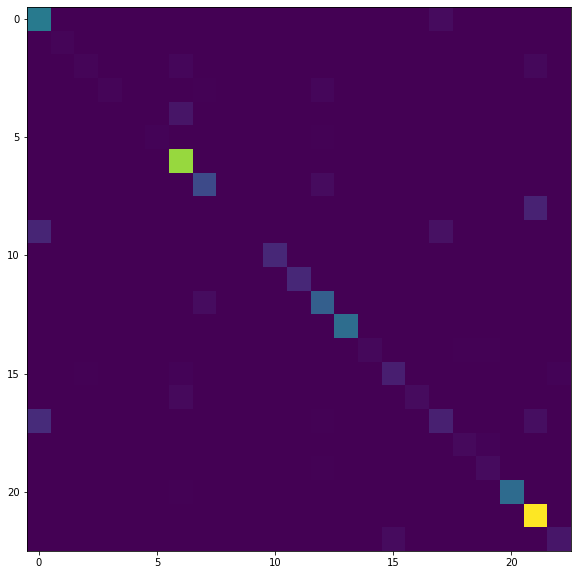

In [27]:
build_confusion_matrix(train_true_event, train_rnn_event, 'training')

In [ ]:
build_confusion_matrix(val_true_event, val_rnn_event, 'validation')

TypeError: ignored

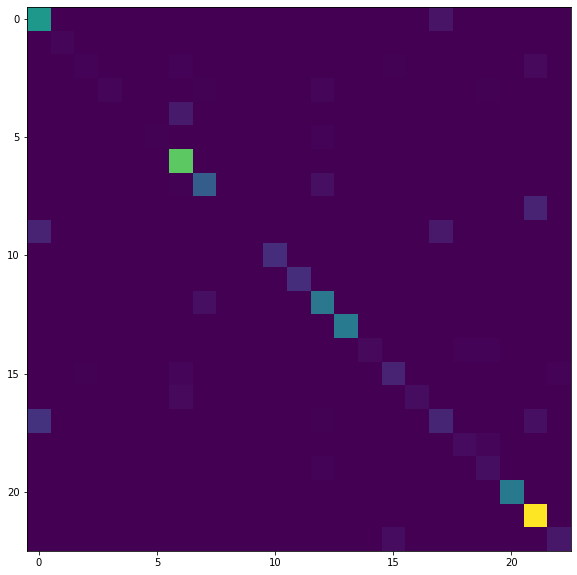

In [28]:
build_confusion_matrix(test_true_event, test_rnn_event, 'test')

# 7. R2 and RMSE and MAE

In [29]:
train_true = df_train['future_time_diff'].tolist()
val_true = df_val['future_time_diff'].tolist()
test_true = df_test['future_time_diff'].tolist()

train_rnn = df_train['RNN_time_diff'].tolist()
val_rnn = df_val['RNN_time_diff'].tolist()
test_rnn = df_test['RNN_time_diff'].tolist()

In [30]:
math.sqrt(mean_squared_error(train_true, train_rnn)), math.sqrt(mean_squared_error(val_true, val_rnn)), math.sqrt(mean_squared_error(test_true, test_rnn))

(0.229848343745834, 0.23286064540668064, 0.23044834925533025)

In [31]:
mean_absolute_error(train_true, train_rnn), mean_absolute_error(val_true, val_rnn), mean_absolute_error(test_true, test_rnn)

(0.15510998190815226, 0.15684790229860607, 0.15477843643724107)

In [32]:
r2_score(train_true, train_rnn), r2_score(val_true, val_rnn), r2_score(test_true, test_rnn)

(0.21137482230283455, 0.20234832922334267, 0.20703407647578198)

In [33]:
df_train.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2012_train_output.csv', index = False)
df_val.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2012_val_output.csv', index = False)
df_test.to_csv('/content/drive/MyDrive/Process Mining RNN/output/bpi2012_test_output.csv', index = False)